In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt

### Graph of communications modelling

In [2]:
# Read the citation_relations.json file and generate a graph
with open('./data/citation_relations.json', 'r') as f:
    cite_data = json.load(f)

In [3]:
# Check if there are duplicate entries in the graph
node_set = set()
for paper_id in cite_data.keys():
    node_set.add(paper_id)
print(f"Duplicates count = {len(cite_data.keys()) - len(node_set)}")

Duplicates count = 0


In [4]:
# Create a list of nodes in the format expected by networkX
node_list = []
for paper_id in cite_data.keys():
    node_list.append({ 'id': paper_id })

In [5]:
link_list = []
for paper_id, paper_data in cite_data.items():
    for ref_paper_id in paper_data['references']:
        link_list.append({ 'source': paper_id, 'target': ref_paper_id })

In [6]:
graph_data = {
    'directed': True,
    'multigraph': False,
    'graph': {},
    'nodes': node_list,
    'links': link_list
}
G_comm = nx.node_link_graph(graph_data)

In [43]:
print(f"Number of nodes = {G_comm.number_of_nodes()}, number of edges = {G_comm.number_of_edges()}")

Number of nodes = 140799, number of edges = 660908


In [9]:
# Subsample the graph in a ratio of 1:10
import random
random.seed(42)
sample_size = len(G_comm.edges) // 10
random_sample_edges = random.sample(list(G_comm.edges), sample_size)
G_comm_sample = nx.Graph()
G_comm_sample.add_edges_from(random_sample_edges)

In [10]:
# Find the largest connected component in the sampled graph
largest_cc = max(nx.connected_components(G_comm_sample), key=len)
G_comm_sample_lcc = G_comm_sample.subgraph(largest_cc)

In [11]:
# Check if the graph is fully connected
print(f"Is the graph fully connected? {nx.is_connected(G_comm_sample_lcc)}")

Is the graph fully connected? True


In [12]:
print(f"Number of nodes = {G_comm_sample_lcc.number_of_nodes()}, number of edges = {G_comm_sample_lcc.number_of_edges()}")

Number of nodes = 32614, number of edges = 39362


### Detect clusters in the graph of communications

In [27]:
clusters_louvain = nx.community.louvain_communities(G_comm, seed=17)

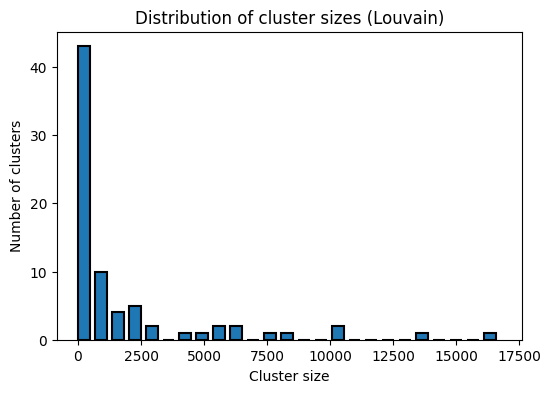

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
number_of_bins = 25
bar_width = 0.7*max([len(c) for c in clusters_louvain]) / number_of_bins
ax.hist([len(c) for c in clusters_louvain], bins=number_of_bins, width=bar_width, linewidth=1.5, edgecolor='black')
ax.set_title('Distribution of cluster sizes (Louvain)')
ax.set_xlabel('Cluster size')
ax.set_ylabel('Number of clusters')
plt.show()

In [32]:
clusters_fluid = list(nx.algorithms.community.asyn_fluidc(G_comm.to_undirected(), 50, seed=17))

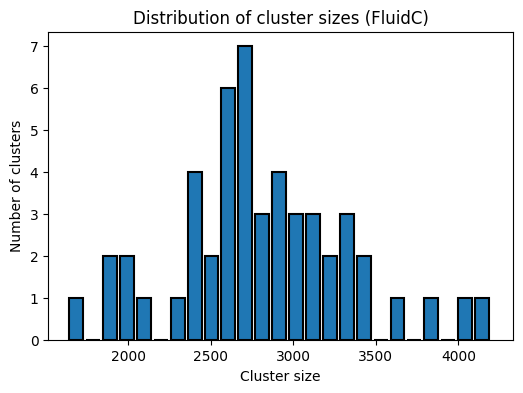

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
number_of_bins = 25
bar_width = 0.5*max([len(c) for c in clusters_fluid]) / number_of_bins
ax.hist([len(c) for c in clusters_fluid], bins=number_of_bins, width=bar_width, linewidth=1.5, edgecolor='black')
ax.set_title('Distribution of cluster sizes (FluidC)')
ax.set_xlabel('Cluster size')
ax.set_ylabel('Number of clusters')
plt.show()

In [40]:
import matplotlib.pyplot as plt

def visualise_cluster(G, cluster):

    # Create a subgraph for the first cluster
    edges = G.subgraph(cluster).edges()
    subgraph = G.subgraph(cluster)

    # Draw the subgraph
    pos = nx.spring_layout(subgraph)
    nx.draw_networkx(subgraph, pos=pos, with_labels=True, node_color='lightblue', edge_color='gray')
    nx.draw_networkx_edges(subgraph, pos=pos, edgelist=edges, edge_color='red')

    plt.show()

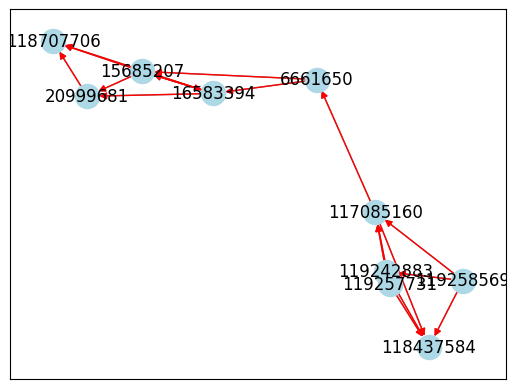

In [41]:
visualise_cluster(G_comm, clusters_louvain[0])

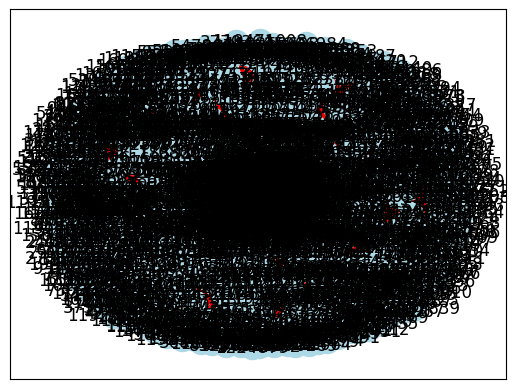

In [42]:
visualise_cluster(G_comm, clusters_louvain[2])

### Graph of similarity of communications modelling

In [58]:
with open('./data/papers.SSN.jsonl', 'r') as f:
    papers = f.readlines()

In [59]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Implement TF-IDF on the paper abstracts
abstracts = []
for paper in papers:
    paper_data = json.loads(paper)
    abstracts.append(" ".join(paper_data['abstract']))

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
abstract_matrix = vectorizer.fit_transform(abstracts)

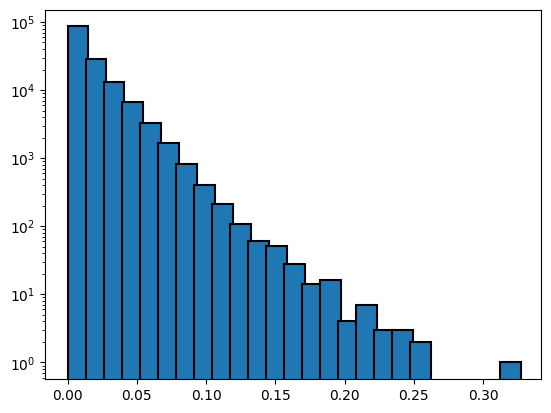

In [19]:
# Calculate the cosine similarity for the first 10000 papers
similarities = cosine_similarity(abstract_matrix[:10000], abstract_matrix)
similarities_arr = similarities.flatten()
similarities_arr = similarities_arr[similarities_arr < 0.99]

# Plot distribution of similarities
fig, ax = plt.subplots()
ax.hist(similarities_arr, bins=25, width=0.015, linewidth=1.5, edgecolor='black')
ax.semilogy()
plt.show()


In [60]:
# Create a list of links based on the cosine similarity in the format required by networkX
link_list = []
_MIN_SIMILARITY_THRESHOLD = 0.2
for source_node, source_data in enumerate(node_list):
    source_paper_id = source_data['id']
    similarities = cosine_similarity(abstract_matrix[source_node], abstract_matrix)
    similarities = similarities.flatten()
    for target_node, cos_sim in enumerate(similarities):
        if cos_sim > _MIN_SIMILARITY_THRESHOLD:
            target_paper_id = json.loads(papers[target_node])['paper_id']
            if target_paper_id != source_paper_id:
                link_list.append({ 'source': source_paper_id, 'target': target_paper_id, 'weight': cos_sim })

In [ ]:
# Create a networkX graph for the similarity graph
similarity_graph_data = {
    'directed': False,
    'multigraph': False,
    'graph': {},
    'nodes': node_list,
    'links': link_list
}
similarity_graph = nx.node_link_graph(graph_data)

'{"paper_id": "4650265", "title": "XGBoost: A Scalable Tree Boosting System", "abstract": ["tree boosting is a highly effective and widely used machine learning method .", "in this paper , we describe a scalable end - to - end tree boosting system called xgboost , which is used widely by data scientists to achieve state - of - the - art results on many machine learning challenges .", "we propose a novel sparsity - aware algorithm for sparse data and weighted quantile sketch for approximate tree learning .", "more importantly , we provide insights on cache access patterns , data compression and sharding to build a scalable tree boosting system .", "by combining these insights , xgboost scales beyond billions of examples using far fewer resources than existing systems ."], "section_names": ["introduction", "tree boosting in a nutshell", "regularized learning objective", "gradient tree boosting", "shrinkage and column subsampling", "basic exact greedy algorithm", "approximate algorithm", 